<a href="https://colab.research.google.com/github/Joshua250304/Cat-Dog-Image-Classifier/blob/main/fcc_cat_dog_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks

import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [26]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-10-13 05:02:00--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M   288MB/s    in 0.2s    

2025-10-13 05:02:00 (288 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                                            directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42
                                        )
val_data_gen = validation_image_generator.flow_from_directory(
                                            directory=validation_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode="binary",
                                            shuffle=True,
                                            seed=42
                                        )
test_data_gen = test_image_generator.flow_from_directory(
                                            directory=PATH,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            classes=['test'],
                                            shuffle=False,
                                            seed=42
                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


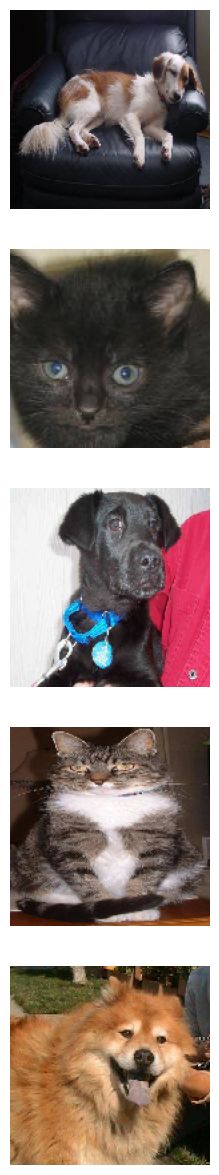

In [15]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [28]:
train_image_generator = ImageDataGenerator(rotation_range=15,
                                            shear_range=0.1,
                                            zoom_range=0.2,
                                            horizontal_flip=True,
                                            width_shift_range=0.1,
                                            height_shift_range=0.1,
                                            rescale=1./255
                                           )

Found 2000 images belonging to 2 classes.


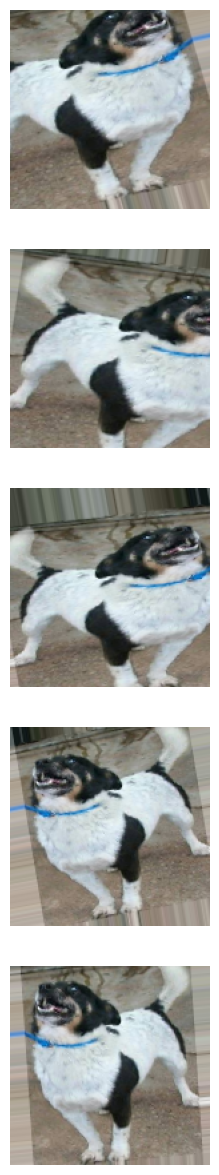

In [29]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [30]:
# network parameters
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.5
num_labels = 2

model = Sequential()
model.add(Conv2D(filters=16,
                  kernel_size=kernel_size,
                  activation='relu',
                  input_shape=input_shape)
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=32,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=64,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=128,
                  kernel_size=kernel_size,
                  activation='relu')
                  )
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add( Dense(1, activation='sigmoid') )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900,513 (3.44 MB)

 Trainable params: 900,513 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

In [32]:
step_size_train=math.ceil(train_data_gen.n / train_data_gen.batch_size)
step_size_valid=math.ceil(val_data_gen.n / val_data_gen.batch_size)

# Stopping condition
callback = callbacks.EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=3,
                                  restore_best_weights=True)

history = model.fit(train_data_gen,
                    epochs=epochs,
                    steps_per_epoch=step_size_train,
                    validation_data=val_data_gen,
                    validation_steps=step_size_valid,
                    callbacks=[callback]
                    )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5247 - loss: 0.7005 - val_accuracy: 0.5030 - val_loss: 0.6878
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 885ms/step - accuracy: 0.5430 - loss: 0.6868 - val_accuracy: 0.5480 - val_loss: 0.6842
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - accuracy: 0.5798 - loss: 0.6795 - val_accuracy: 0.6440 - val_loss: 0.6438
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 915ms/step - accuracy: 0.6240 - loss: 0.6634 - val_accuracy: 0.5750 - val_loss: 0.6724
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 963ms/step - accuracy: 0.5825 - loss: 0.6696 - val_accuracy: 0.6140 - val_loss: 0.6565
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 897ms/step - accuracy: 0.6410 - loss: 0.6494 - val_accuracy: 0.6640 - val_loss: 0.6314
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 870ms/step - accuracy: 0.6507 - loss: 0.6204 - val_accuracy: 0.6730 - val_loss: 0.6133
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 867ms/step - accuracy: 0.6830 - loss: 0.6071 - val_accurac

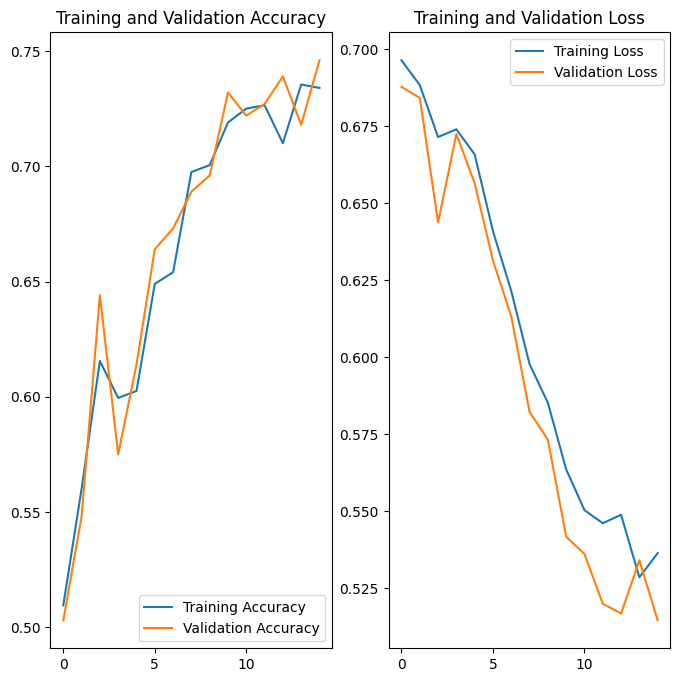

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step


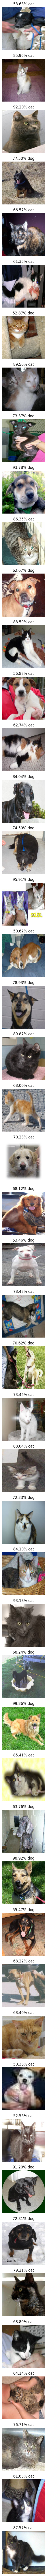

In [34]:
probabilities = model.predict(test_data_gen)
probabilities = probabilities.reshape(-1)
probabilities = probabilities.tolist()

sample_testing_images, _ = next(test_data_gen)
plotImages(sample_testing_images, probabilities = probabilities)

In [37]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.8% of the images of cats and dogs.
You passed the challenge!
